
# 01_explore_habloss
Exploration of HABLOSS VHR imagery and land-take masks + simple proof of concept CNN.


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import rasterio
from torch.utils.data import Dataset, DataLoader

# add repo root
root = Path().resolve().parents[0]
sys.path.append(str(root))

from src.config import VHR_DIR, MASK_DIR
from src.data.habloss_dataset import HablossSampleDataset


## Data Exploration

Under er et script som:
- printer img.shape og mask.shape
- plotter én RGB composite (første 3 bands), og masken 

VHR_DIR: C:\Users\emma\Documents\Land-Take-Prediction-Project-NINA-\data\raw\vhr
MASK_DIR: C:\Users\emma\Documents\Land-Take-Prediction-Project-NINA-\data\raw\masks
Files in VHR_DIR:
  a-0-47134313698222_52-09242527089813_RGBY_Mosaic.tif
  a-0-54402407469629_44-04188024421709_RGBY_Mosaic.tif
  a-0-77133618972711_46-45684360844514_RGBY_Mosaic.tif
  a-1-18139547412802_52-25772329329998_RGBY_Mosaic.tif
  a-1-34144867248374_47-02619422462487_RGBY_Mosaic.tif
  a-1-58467935875357_47-05443474717619_RGBY_Mosaic.tif
  a-18-03071366712101_65-66474845645646_RGBY_Mosaic.tif
  a-2-17104025185075_39-66195264271502_RGBY_Mosaic.tif
  a-2-22932139889146_56-95862408026678_RGBY_Mosaic.tif
  a-2-52025858362194_53-72050616794933_RGBY_Mosaic.tif
  a-2-59185730215767_53-11198720241597_RGBY_Mosaic.tif
  a-3-82567804883019_40-09254102374404_RGBY_Mosaic.tif
  a-3-99571454125387_43-28658119907893_RGBY_Mosaic.tif
  a-4-04049538502545_47-97554982426387_RGBY_Mosaic.tif
  a-6-53797725923809_53-84911799426187_RGBY_Mo

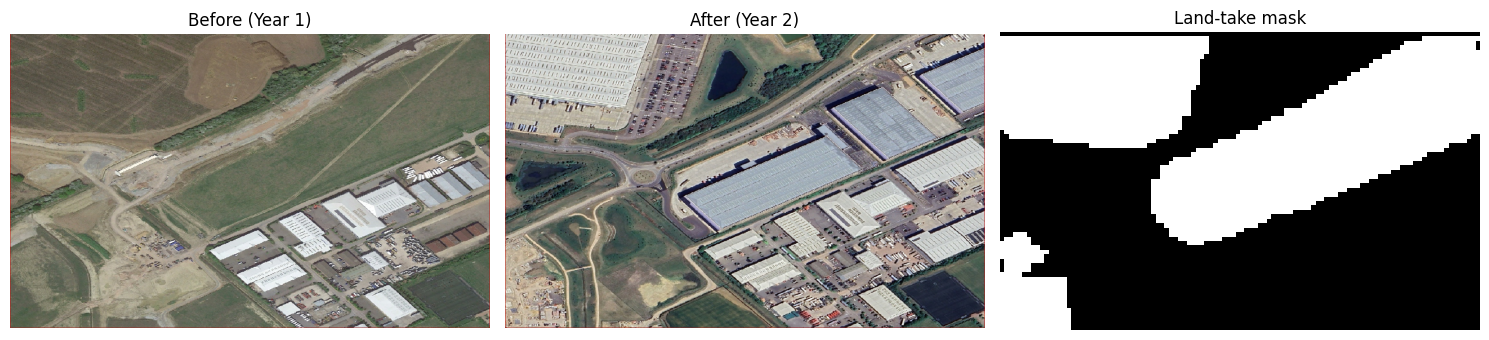

In [3]:

print("VHR_DIR:", VHR_DIR)
print("MASK_DIR:", MASK_DIR)

# list the files Python sees
print("Files in VHR_DIR:")
for p in VHR_DIR.glob("*.tif"):
    print(" ", p.name)

# id of one tile to visualize
fname = "a-0-47134313698222_52-09242527089813"

vhr_path = VHR_DIR / f"{fname}_RGBY_Mosaic.tif"
mask_path = MASK_DIR / f"{fname}_mask.tif"

with rasterio.open(vhr_path) as src:
    img = src.read()          # (bands, H, W)
    print("VHR shape:", img.shape)

with rasterio.open(mask_path) as src_m:
    mask = src_m.read(1)      # (H, W)
    print("Mask shape:", mask.shape)

# quick RGB plot using first 3 bands (year 1 = BEFORE)
before = np.stack([img[0], img[1], img[2]], axis=-1)
before = (before - before.min()) / (before.max() - before.min() + 1e-6)

# RGB using last 3 bands (year 2 = AFTER)
after = np.stack([img[3], img[4], img[5]], axis=-1)
after = (after - after.min()) / (after.max() - after.min() + 1e-6)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(before)
ax[0].set_title("Before (Year 1)")
ax[0].axis("off")

ax[1].imshow(after)
ax[1].set_title("After (Year 2)")
ax[1].axis("off")

ax[2].imshow(mask, cmap="gray")
ax[2].set_title("Land-take mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()




Scriptet under henter ut IDene til tilesene som er lagret i data/raw/vhr, og 

In [4]:

# find all *_RGBY_Mosaic.tif files
all_vhr_files = list(VHR_DIR.glob("*_RGBY_Mosaic.tif"))

# extract ID (filename without suffix)
ids = [f.stem.replace("_RGBY_Mosaic", "") for f in all_vhr_files]

print("Found", len(ids), "IDs in VHR_DIR")


ds = HablossSampleDataset(ids)

for i, fid in enumerate(ids):
    img, mask = ds[i]
    print(f"{i+1}. {fid}")
    print("   image shape:", img.shape)
    print("   mask  shape:", mask.shape)



Found 54 IDs in VHR_DIR
1. a-0-47134313698222_52-09242527089813
   image shape: torch.Size([6, 656, 1069])
   mask  shape: torch.Size([67, 108])
2. a-0-54402407469629_44-04188024421709
   image shape: torch.Size([6, 655, 913])
   mask  shape: torch.Size([66, 92])
3. a-0-77133618972711_46-45684360844514
   image shape: torch.Size([6, 654, 950])
   mask  shape: torch.Size([66, 95])
4. a-1-18139547412802_52-25772329329998
   image shape: torch.Size([6, 658, 1071])
   mask  shape: torch.Size([67, 108])
5. a-1-34144867248374_47-02619422462487
   image shape: torch.Size([6, 657, 963])
   mask  shape: torch.Size([67, 98])
6. a-1-58467935875357_47-05443474717619
   image shape: torch.Size([6, 658, 963])
   mask  shape: torch.Size([67, 97])
7. a-18-03071366712101_65-66474845645646
   image shape: torch.Size([6, 662, 1603])
   mask  shape: torch.Size([67, 162])
8. a-2-17104025185075_39-66195264271502
   image shape: torch.Size([6, 658, 852])
   mask  shape: torch.Size([66, 86])
9. a-2-2293213988

In [6]:

img, mask = ds[0]
C, H, W = img.shape

mask_t = mask.unsqueeze(0).unsqueeze(0).float()      # (1,1,h,w)
mask_up = F.interpolate(mask_t, size=(H, W), mode="nearest")
mask_up = mask_up.squeeze(0).squeeze(0).long()       # (H, W)

print(img.shape, mask_up.shape)


torch.Size([6, 656, 1069]) torch.Size([656, 1069])


## Pre processing

### Patching
Cut images into 128*128 patches.

first a test on one 

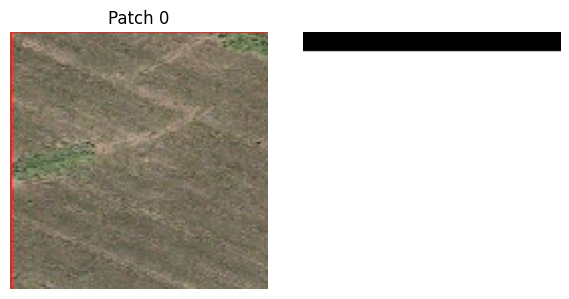

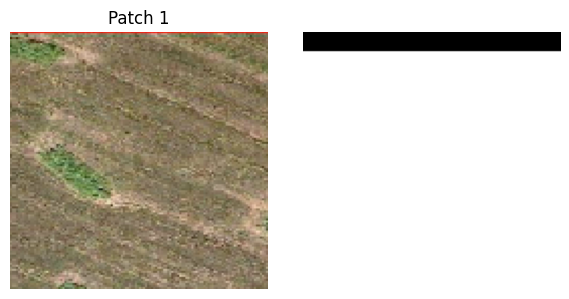

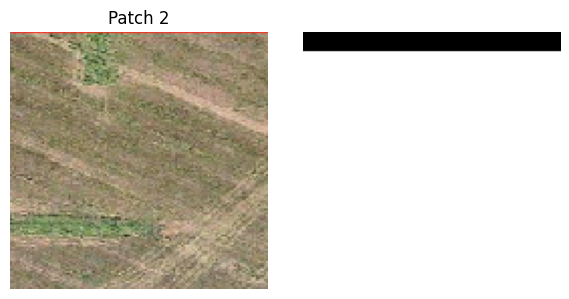

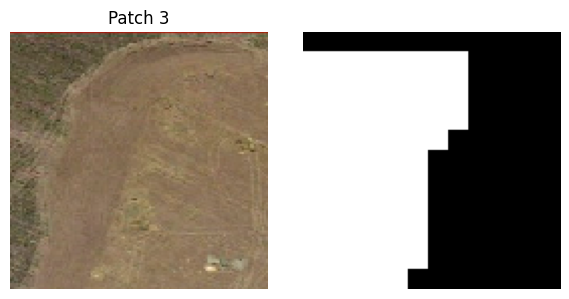

In [7]:
import torch
import torch.nn.functional as F

PATCH_SIZE = 128
STRIDE = 128

def upsample_mask(mask, H, W):
    mask_t = mask.unsqueeze(0).unsqueeze(0).float()        # (1,1,h,w)
    mask_up = F.interpolate(mask_t, size=(H, W), mode="nearest")
    return mask_up.squeeze(0).squeeze(0).long()            # (H, W)

def get_patches(img, mask, patch_size=PATCH_SIZE, stride=STRIDE):
    C, H, W = img.shape
    patches = []
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            img_patch = img[:, i:i+patch_size, j:j+patch_size]
            mask_patch = mask[i:i+patch_size, j:j+patch_size]
            patches.append((img_patch, mask_patch))
    return patches

all_patches = []

for fid in ids:
    img, mask = ds[ids.index(fid)]          # or loop with enumerate(ds)
    C, H, W = img.shape
    mask_up = upsample_mask(mask, H, W)

    # simple normalization 0–1
    img = img.float()
    img = img / (img.max() + 1e-6)

    patches = get_patches(img, mask_up)
    all_patches.extend(patches)

len(all_patches), all_patches[0][0].shape, all_patches[0][1].shape

# visualize some patches
patches = all_patches
for i in range(4): # number of patches to visualize
    img_patch, mask_patch = patches[i]
    rgb_patch = np.stack([img_patch[0], img_patch[1], img_patch[2]], axis=-1)
    rgb_patch = (rgb_patch - rgb_patch.min()) / (rgb_patch.max() - rgb_patch.min() + 1e-6)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(rgb_patch)
    ax[0].set_title(f"Patch {i}")
    ax[0].axis("off")

    ax[1].imshow(mask_patch, cmap="gray")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()




### Normalization
Normalize pixel values to same scale (temp. global normalization)

In [8]:
img = img.float()
img = img / img.max()   # scale to 0–1 range. divides by the value of largest pixel in the entire image (largest pixel -> highest RGB values)
#Normalize per channel later?


## Simple CNN Model

Build a basic CNN for land-take segmentation.

### Step 1: Create a PyTorch Dataset from patches

In [9]:
class PatchDataset(Dataset):
    """PyTorch Dataset wrapper for image patches."""
    def __init__(self, patches):
        self.patches = patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        img_patch, mask_patch = self.patches[idx]
        return img_patch.float(), mask_patch.long()

# Create dataset and split into train/val (80/20 train/validation)
from sklearn.model_selection import train_test_split

train_patches, val_patches = train_test_split(all_patches, test_size=0.2, random_state=42) 

train_dataset = PatchDataset(train_patches)
val_dataset = PatchDataset(val_patches)

print(f"Training patches: {len(train_dataset)}")
print(f"Validation patches: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Training patches: 1608
Validation patches: 402


### Step 2: Define a simple CNN architecture

In [10]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    """Simple CNN for binary semantic segmentation."""
    def __init__(self, in_channels=6, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder (upsampling)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 64)
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(32, 32)
        
        # Final classifier
        self.out = nn.Conv2d(32, num_classes, kernel_size=1)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        x1 = self.enc1(x) 
        x2 = self.pool(x1)
        
        x2 = self.enc2(x2)
        x3 = self.pool(x2)
        
        x3 = self.enc3(x3)
        
        # Decoder
        x = self.up1(x3)  
        x = self.dec1(x)  
        
        x = self.up2(x)   
        x = self.dec2(x)  
        
        # Output
        x = self.out(x)   
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(in_channels=6, num_classes=2).to(device)

print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Model parameters: 422,626


### Step 3: Training loop

In [11]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == masks).sum().item()
        total += masks.numel()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == masks).sum().item()
            total += masks.numel()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

print("Training setup complete!")

Training setup complete!


### Step 4: Train the model

In [12]:
# Train for a few epochs
num_epochs = 10

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

print("Training complete!")

Epoch 1/10
  Train Loss: 0.3545, Train Acc: 85.92%
  Val Loss: 0.5912, Val Acc: 71.62%

Epoch 2/10
  Train Loss: 0.2924, Train Acc: 88.46%
  Val Loss: 0.2104, Val Acc: 92.40%

Epoch 3/10
  Train Loss: 0.2815, Train Acc: 88.87%
  Val Loss: 0.2157, Val Acc: 92.86%

Epoch 4/10
  Train Loss: 0.2624, Train Acc: 89.48%
  Val Loss: 0.1834, Val Acc: 93.14%

Epoch 5/10
  Train Loss: 0.2592, Train Acc: 89.74%
  Val Loss: 0.2332, Val Acc: 90.97%

Epoch 6/10
  Train Loss: 0.2534, Train Acc: 89.98%
  Val Loss: 0.2340, Val Acc: 90.20%

Epoch 7/10
  Train Loss: 0.2544, Train Acc: 89.98%
  Val Loss: 0.1820, Val Acc: 93.50%

Epoch 8/10
  Train Loss: 0.2527, Train Acc: 89.70%
  Val Loss: 0.3046, Val Acc: 86.44%

Epoch 9/10
  Train Loss: 0.2374, Train Acc: 90.63%
  Val Loss: 0.2150, Val Acc: 92.04%

Epoch 10/10
  Train Loss: 0.2485, Train Acc: 90.13%
  Val Loss: 0.2172, Val Acc: 91.28%

Training complete!


### Step 5: Visualize training progress

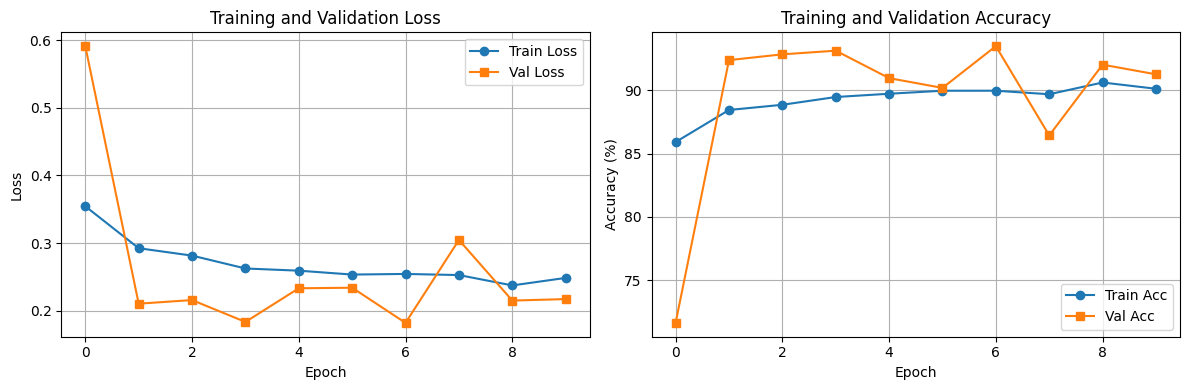

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Train Acc', marker='o')
ax2.plot(val_accs, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()